In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import glob, os
import yaml
from scipy.integrate import solve_ivp
import pprint
import pickle
from matplotlib.ticker import EngFormatter
from matplotlib import ticker

In [2]:
def get_config(fname):
    conf = {}
    if os.path.exists(fname):
        with open(fname) as f: 
            conf = yaml.load(f, Loader = yaml.FullLoader)
    else:
        print('No yaml config file!')
    return conf

In [3]:
def hydro(t, f, a, mu, tau):
    q1, q2, r = f
    return [q1*(2*a**2*tau*q2 - mu*(q1-q2)*q1*r),
            (q1-q2)*r*(q1**2 - a**2),
            tau*q2*r*(q1**2 - a**2)]

In [4]:
def is_white(point, epsilon): 
    q1, q2, r = point
    res = {'line': {}, 'int': {}, 'dist': {}}
    
    analytical = np.array([1, q2, 2*a*tau*q2/mu/(a - q2)])
    numerical = np.array([q1, q2, r])
    norm = np.sqrt(np.sum(list(map(lambda x: x**2, analytical))))
    distance = np.sqrt((a - q1)**2 + (r - 2*a*tau*q2/mu/(a - q2))**2)/norm
    # print('### analytical', analytical)
    # print('### numerical', numerical)
    # print('### distance', distance)
    
    ### правда ли, что точка вблизи линии ?
    if distance < epsilon:
        res['line'] = True
        res['dist'] = distance
    else:
        res['line'] = False
    ### правда ли, что точка попала в интервал по q2 ?   
    if q2 >= white_bounds[0] and q2 <= white_bounds[1]:
        res['int'] = True
    else:
        res['int'] = False
    # print('### ans', res)
    return res

In [5]:
def hydroj(t, f, a, mu, tau):
    q1, q2, r = f
    return [[2*a**2*tau*q2 - 3*mu*q1**2*r + 2*mu*q1*q2*r, 2*a**2*tau*q1 + mu*q1**2*r, -mu*q1**3 + mu*q1**2*q2], \
            [3*r*q1**2 - a**2*r - 2*r*q1*q2, -r*q1**2 + a**2*r, q1**3 - a**2*q1 - q1**2*q2 + a**2*q2], \
            [2*tau*q1*q2*r, tau*q1**2*r - tau*a**2*r, tau*q1**2*q2 - tau*a**2*q2]]

In [6]:
def printer(ans):
    print('### Метод РК45 \n### Движение вперед')
    print('Метод Рунге при движении вперед остановился в состоянии', ans['RK_45']['plus'].status, \
          '###', ans['RK_45']['plus'].message)
    if ans['RK_45']['plus'].status != 0:
        print('События, приведшие к остановке метода Рунге', ans['RK_45']['plus'].t_events )
    print('Количество итераций решателя Рунге до остановки', ans['RK_45']['plus'].nfev )
    print('### Движение назад')
    print('Метод Рунге при движении назад остановился в состоянии', ans['RK_45']['minus'].status, \
          '###', ans['RK_45']['minus'].message)
    if ans['RK_45']['minus'].status != 0:
        print('События, приведшие к остановке метода Рунге', ans['RK_45']['minus'].t_events )
    print('Количество итераций решателя Рунге до остановки', ans['RK_45']['minus'].nfev )

    print('### Метод LSODA \n###Движение вперед')
    print('Метод LSODA при движении вперед остановился в состоянии', ans['LSODA']['plus'].status, \
          '###', ans['LSODA']['plus'].message)
    if ans['LSODA']['plus'].status != 0:
        print('События, приведшие к остановке метода LSODA', ans['LSODA']['plus'].t_events )
    print('Количество итераций решателя LSODA до остановки', ans['LSODA']['plus'].nfev )
    print('Количество вычислений якобиана', ans['LSODA']['plus'].njev )
    print('###Движение назад')
    print('Метод LSODA при движении назад остановился в состоянии', ans['LSODA']['minus'].status, \
          '###', ans['LSODA']['minus'].message)
    if ans['LSODA']['minus'].status != 0:
        print('События, приведшие к остановке метода LSODA', ans['LSODA']['minus'].t_events )
    print('Количество итераций решателя LSODA до остановки', ans['LSODA']['minus'].nfev )

In [7]:
### События останова: и переход через ноль по q2
### 1. уход на бесконечность по радиусу
def r_inf(t, f, a, mu, tau):
    # f[2] - это радиус
    return f[2] - r_infty
### 2. переход через ноль по q2
def q2_0(t, f, a, mu, tau):
    # f[1] - это КУ-2
    return f[1]
### трансзвуковые переходы для двух компонент
def q1_pa(t, f, a, mu, tau):
    # f[0] - это КУ-1
    return f[0] - a
def q1_ma(t, f, a, mu, tau):
    # f[0] - это КУ-1
    return f[0] - a
def q2_pa(t, f, a, mu, tau):
    # f[0] - это КУ-1
    return f[1] - a
def q2_ma(t, f, a, mu, tau):
    # f[0] - это КУ-1
    return f[1] - a

r_inf.terminal = True
r_inf.direction = +1
q2_0.terminal = True
q2_0.direction = -1
q1_pa.terminal = False
q1_pa.direction = +1
q1_ma.terminal = False
q1_ma.direction = -1
q2_pa.terminal = False
q2_pa.direction = +1
q2_ma.terminal = False
q2_ma.direction = -1

In [8]:
def postproc(ans, direct, result):
    result[direct] = {}
    events = ['q1_ma', 'q1_pa', 'q2_ma', 'q2_pa', 'q2_0', 'r_inf']
    mask = list(map( lambda x: x.size > 0, ans['RK_45'][direct].t_events))
    ev_tlist = np.array(ans['RK_45'][direct].t_events)[mask].tolist()
    ev_ylist = np.array(ans['RK_45'][direct].y_events)[mask].tolist()
    ev_nlist = np.array(events)[mask].tolist()
    for k, key in enumerate(ev_nlist):
        result[direct][key] = {}
        result[direct][key]['time'] = ev_tlist[k]
        result[direct][key]['vars'] = ev_ylist[k]
    if ans['RK_45'][direct].status == 1:
        result[direct]['last'] = {}
        result[direct]['last']['time'] = ev_tlist[-1][0]
        result[direct]['last']['vars'] = ev_ylist[-1][0]
    elif ans['RK_45'][direct].status == 0:
        result[direct]['last'] = {}
        result[direct]['last']['time'] = ans['RK_45'][direct].t[-1]
        var = np.array(list(map( lambda x: ans['RK_45'][direct].y[x][-1], [0,1,2])))
        result[direct]['last']['vars'] = var
        # np.array(map(lambda x: ans['RK_45'][direct].y[x][-1],[0,1,2]))
    else:
        print('### We have a problem!!! The priblem is: ', ans['RK_45'][direct].message)
    return result

In [9]:
def solver(system, jac, times, minstep, init_point, sys_pars, events, atol, rtol):
    ### system - система уравнений
    ### jac - якобиан системы уравнений
    ### times - время на плюс-, минус-бесконечности, число точек на графике, признак расчета промежуточных точек
    tp_end = times['t_plus']
    tm_end = times['t_minus']
    # atol = 1E-9
    # rtol = 1E-6
    # atol = 1E-8
    # rtol = 1E-5
    ans = {}
    ans['RK_45'] = {}
    ans['LSODA'] = {}
    
    ### движение вперед
    sol = solve_ivp(system, [0, tp_end], init_point, method='RK45', atol = atol, rtol = rtol, args=sys_pars,                   dense_output=True, events=events)
    ans['RK_45']['plus'] = sol
    #sol = solve_ivp(system, [0, tp_end], init_point, method='LSODA', jac = hydroj, atol = atol, rtol = rtol, args=sys_pars, \
    #              min_step = minstep, dense_output=True, events=events)
    ans['LSODA']['plus'] = sol
    ### движение назад
    sol = solve_ivp(system, [0, tm_end], init_point, method='RK45',atol = atol, rtol = rtol, args=sys_pars,                   dense_output=True, events=events)
    ans['RK_45']['minus'] = sol
    #sol = solve_ivp(system, [0, tm_end], init_point, method='LSODA', jac = hydroj, atol = atol, rtol = rtol, args=sys_pars, \
    #              min_step = minstep, dense_output=True, events=events)
    ans['LSODA']['minus'] = sol
    
    result = {}
    result = postproc(ans, 'plus', result)
    result = postproc(ans, 'minus', result)
    return result, ans

In [10]:
def classificator(init_point, points, atol, rtol):
    ### отслеживаются все-на-свете события, они заданы в postproc
    ### обработка области №1
    ### задается только обработка событий для останова: пересечение нуля, уход на бесконечность
    if   init_point[0] <= a and init_point[1] >= a: 
        color, init, pend, mend = test1(init_point, atol, rtol)
    ### обработка области №2
    ### задается только обработка событий: 
    ###   - пересечение скорости звука по  q1 "сверх -> до",
    ###   - пересечение нуля, 
    ###   - уход на бесконечность
    elif init_point[0] >= a and init_point[1] >= a:
        color, init, pend, mend = test2(init_point, atol, rtol)
    ### обработка области №3
    ### задается только обработка событий: 
    ###   - пересечение скорости звука по  q1 "сверх -> до",
    ###   - пересечение нуля, 
    ###   - уход на бесконечность
    elif init_point[0] >= a and init_point[1] <= a:
        color, init, pend, mend = test3(init_point, atol, rtol)
    ### обработка области №4
    ### задается только обработка событий: 
    ###   - пересечение скорости звука по  q1 "сверх -> до",
    ###   - пересечение нуля, 
    ###   - уход на бесконечность
    elif init_point[0] <= a and init_point[1] <= a:
        color, init, pend, mend = test4(init_point, atol, rtol)
    else:
        print('Fuck!!! \nI am on the sound speed line and can\'t detect the point\'s type')
        color = 'smth'
        init = init_point
        pend = []
        mend = []
    points[color]['init'].append(init_point)
    points[color]['pend'].append(pend)
    points[color]['mend'].append(mend)
    return points         

In [11]:
def test1(init_point, atol, rtol):
    ### пока для тестирование даже в априорно красной области уравнения решаются
    ### для того, чтобы можно было контролировать траектории
    ### потом после тестирования процедуру можно будет упростить
    ### запуск решения из начальной точки до заданных моментов времени в плюс и минус
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    color = 'red'
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r]  
    return color, init, pend, mend

In [12]:
def test2(init_point, atol, rtol):
    ### решаем задачку и по решению собираем все нужные события
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    ### события пересечения скорости звука "сверх -> до" при движении в минус
    q1_ma = sln['RK_45']['minus'].t_events[0]
    ### события пересечения нуля при движении в минус
    q2_0  = sln['RK_45']['minus'].t_events[1]
    # r_inf  = sln['RK_45']['minus'].t_events[2]
    if 'q1_ma' and 'q2_0' in result['minus'].keys():
        color = 'green'
    elif 'q1_ma' in result['minus'].keys():
        color = 'red'
    
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r] 
    return color, init, pend, mend

In [13]:
def test3(init_point, atol, rtol):
    ### решаем задачку и по решению собираем все нужные события
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    mpoint = result['minus']['last']['vars']
    ppoint = result['plus']['last']['vars']
    res = is_white(ppoint, epsilon)
    if res['line']*res['int']:
        if 'q2_0' in result['minus'].keys():
            color = 'white_0'
        else:
            color = 'white_1'
    else:
        if ppoint[0] <= a:
            color = 'black'
        else:
            if mpoint[0] <= a:
                color = 'red'
            else:
                if 'q2_0' in result['minus'].keys():
                    color = 'green'
                else:
                    color = 'smth'
        
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r] 
    return color, init, pend, mend

In [14]:
def test4(init_point, atol, rtol):
    ### решаем задачку и по решению собираем все нужные события
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    mpoint = result['minus']['last']['vars']
    ppoint = result['plus']['last']['vars']    
    ### далее цепочка вопросов
    ### вопрос номер один: белая?
    res = is_white(ppoint, epsilon)
    if res['line']*res['int']:
        if 'q2_0' in result['minus'].keys():
            color = 'white_0'
        else:
            color = 'white_1'
    else:
        if ppoint[0] > a or ppoint[1] > a :
            color = 'red'
        else:
            if mpoint[0] > a:
                color = 'black'
            else:
                if 'q2_0' in result['plus'].keys() and mpoint[0] < delta*init_point[0]:
                    color = 'blue'
                else:
                    color = 'smth'
        
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r] 
    return color, init, pend, mend

In [15]:
# "новые" алгоритмы проверки на тип
def test1(init_point, atol, rtol):
    ### пока для тестирование даже в априорно красной области уравнения решаются
    ### для того, чтобы можно было контролировать траектории
    ### потом после тестирования процедуру можно будет упростить
    ### запуск решения из начальной точки до заданных моментов времени в плюс и минус
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    color = 'red'
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r]  
    return color, init, pend, mend

def test2(init_point, atol, rtol):
    ### решаем задачку и по решению собираем все нужные события
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    if 'q2_ma' and 'q2_0' in result['minus'].keys():
        color = 'green'
    elif 'q1_ma' in result['minus'].keys():
        color = 'red'
    else:
        color = 'smth'
    
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r] 
    return color, init, pend, mend

def test3(init_point, atol, rtol):
    ### решаем задачку и по решению собираем все нужные события
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    mpoint = result['minus']['last']['vars']
    ppoint = result['plus']['last']['vars']
    res = is_white(ppoint, epsilon)
    if res['line']*res['int']:
        if 'q2_0' in result['minus'].keys():
            color = 'white_0'
        else:
            color = 'white_1'
    else:
        if ppoint[0] <= a:
            color = 'black'
        else:
            if mpoint[0] <= a:
                color = 'red'
            else:
                if 'q2_0' in result['minus'].keys():
                    color = 'green'
                else:
                    color = 'smth'
        
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r] 
    return color, init, pend, mend

def test4(init_point, atol, rtol):
    ### решаем задачку и по решению собираем все нужные события
    result, sln = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol, rtol)
    mpoint = result['minus']['last']['vars']
    ppoint = result['plus']['last']['vars']    
    ### далее цепочка вопросов
    ### вопрос номер один: белая?
    res = is_white(ppoint, epsilon)
    if res['line']*res['int']:
        if 'q2_0' in result['minus'].keys():
            color = 'white_0'
        else:
            color = 'white_1'
    else:
        if ppoint[0] > a or ppoint[1] > a :
            color = 'red'
        else:
            if mpoint[0] > a:
                color = 'black'
            else:
                if 'q2_0' in result['plus'].keys() and mpoint[0] < delta*init_point[0]:
                    color = 'blue'
                else:
                    color = 'smth'
        
    init = [0] + init_point
    t = result['minus']['last']['time']
    q1, q2, r = result['minus']['last']['vars']
    mend = [t, q1, q2, r]
    t = result['plus']['last']['time']
    q1, q2, r = result['plus']['last']['vars']
    pend = [t, q1, q2, r] 
    return color, init, pend, mend

In [16]:
def clear(points):
    points = {'red':   {'init': [], 'pend': [], 'mend': []}, \
          'green': {'init': [], 'pend': [], 'mend': []}, \
          'blue':  {'init': [], 'pend': [], 'mend': []}, \
          'black': {'init': [], 'pend': [], 'mend': []}, \
          'white_0': {'init': [], 'pend': [], 'mend': []}, \
          'white_1': {'init': [], 'pend': [], 'mend': []}, \
          'smth':  {'init': [], 'pend': [], 'mend': []}}
    return points

In [17]:
### РНД-шка ###
# params = get_config('/Users/vovka/Documents/math/2020/01_panov/python/params.yaml')
params = get_config('params.yaml')
### Константы задачи
a = float(params["const"]["a"])
mu = float(params["const"]["mu"])
tau = float(params["const"]["tau"])
sys_pars = (a, mu, tau)
### Параметры для решателя 
### 1. времена задачи
tp = float(params["glob_left"])
pfinal = tp
tm = float(params["glob_right"])
mfinal = tm
times = {'t_plus': tp, 't_minus': tm, 'plot': False, 'n_time_points': 2}
### 2. тип решателя минимальный шаг по времени
int_meth = params['solver']['meth']
minstep =  float(params['solver']['minstep'])
### 3. обработка особых случаев
###  линии особых точек (эпсилон-окрестность и границы по  q2)
epsilon = float(params['eps_w'])
white_bounds = [a/2*(1 - np.sqrt(1 - 8/mu)), a/2*(1 + np.sqrt(1 - 8/mu))]
###  насколько конечная координата по q1 должна быть меньше начальной в признаке синих
delta = float(params['delta_blue'])
###  когда останавливать счет по признаку выхода на бесконечность
r_infty = float(params['infty'])
### 4. начальный словарь точек для заполнения
points = {'red':   {'init': [], 'pend': [], 'mend': []}, \
          'green': {'init': [], 'pend': [], 'mend': []}, \
          'blue':  {'init': [], 'pend': [], 'mend': []}, \
          'black': {'init': [], 'pend': [], 'mend': []}, \
          'white_0': {'init': [], 'pend': [], 'mend': []}, \
          'white_1': {'init': [], 'pend': [], 'mend': []}, \
          'smth':  {'init': [], 'pend': [], 'mend': []}}
events = ['q1_ma', 'q1_pa', 'q2_ma', 'q2_pa', 'q2_0', 'r_inf']

In [18]:
# mu = 4
# + r_01_mu_04_fig_01 red (1, 10^0.5, 1)
# + r_01_mu_04_fig_02 green (10, 1, 1)
# + r_01_mu_04_fig_03 gray (1, 0.1, 1)
# + r_01_mu_04_fig_04 blue (0.1, 0.1, 1) # тут оказалось надо слишком долго идти до -10000, иначе слева не доходит до критерия  близости к нулю

# mu = 16
# + r_01_mu_16_fig_01 red = (1, 1, 0.01)
# + r_01_mu_04_fig_02 light_red (0.1, 0.1 , 0.01)
# + r_01_mu_04_fig_03 green (10, 10^{-0.5}, 0.01)
# + r_01_mu_04_fig_04 light_green (10^{0.75}, 0.1, 0.01)
# + r_01_mu_04_fig_05 gray (1, 10^{-1.5} , 0.01)
# + r_01_mu_04_fig_06 blue (0.1, 10^{-1.5}, 0.01)

# mu = 16
# r_01_mu_04_fig_01 red = (0.1, 1, 1)
# r_01_mu_04_fig_02 light_red (10^{-1.75}, 0.1 , 1)
# r_01_mu_04_fig_03 green (10, 1, 1)
# r_01_mu_04_fig_04 light_green (1, 10^{-0.055}, 1)
# r_01_mu_04_fig_05 gray (10, 0.1 , 1)
# r_01_mu_04_fig_06 blue (0.1, 0.1, 1)

# mu = 4
# r_01_mu_04_fig_01 green (10, 10^{-5}, 1)
# r_01_mu_04_fig_02 gray (1, 10^{-5} , 1)
# r_01_mu_04_fig_03 blue (0.1, 10^{-5}, 1)

# mu = 4
# r_01_mu_04_fig_01 green (10^{1.25}, 10^{-5}, 0.01)
# r_01_mu_04_fig_02 light_green (10^{0.75}, 10^{-5}, 0.01)
# r_01_mu_04_fig_03 gray (1,   10^{-5} , 0.01)
# r_01_mu_04_fig_04 blue (0.1, 10^{-5}, 0.01)

In [25]:
### тестирование отдельных траекторий
### Общие параметры задачи
points = clear(points)
times = {'t_plus': 1000, 't_minus': -1000, 'plot': False, 'n_time_points': 1000}
### mu = 4
# fname = './figures/r_01_mu_04_fig_01_red'
# init_point = [1, 10**(0.5), 1]
# fname = './figures/r_01_mu_04_fig_02_green'
# init_point = [10, 1, 1]
# fname = './figures/r_01_mu_04_fig_02_gray'
# init_point = [1, 0.1, 1]
# fname = './figures/r_01_mu_04_fig_04_blue'
# init_point = [0.1, 0.1, 1]
### mu = 16
# fname = './figures/r_01_mu_16_fig_01_red'
# init_point = [1, 1, 0.01]
# fname = './figures/r_01_mu_16_fig_02_light_red'
# init_point = [0.1, 0.1 , 0.01]
# fname = './figures/r_01_mu_16_fig_03_green'
# init_point = [10, 10**(-0.5), 0.01]
# fname = './figures/r_01_mu_16_fig_03_green'
# init_point = [10, 10**(-0.5), 0.01]
# fname = './figures/r_01_mu_16_fig_03_light_green'
# init_point = [10**0.75, 0.1, 0.01]
# fname = './figures/r_01_mu_16_fig_05_gray'
# init_point = [1, 10**(-1.5) , 0.01]
# r_01_mu_16_fig_05 gray (1, 10^{-1.5} , 0.01)
mu = 16
fname = './figures/r_01_mu_16_fig_03_light_green'
init_point = [10**0.75, 0.1, 0.01]
# r_01_mu_16 _fig_06 blue (0.1, 10^{-1.5}, 0.01)

atol = 1E-6*np.array([1,0.5, 0.5**2, 0.5**3, 0.5**4, 0.5**5, 0.5**6])
rtol = 1E-3*np.array([1,0.5, 0.5**2, 0.5**3, 0.5**4, 0.5**5, 0.5**6])
events = (q1_ma, q1_pa, q2_ma, q2_pa, q2_0, r_inf)
points = classificator(init_point, points, atol[0], rtol[0])
pprint.pprint(points)
### решение основной системы
### тест на сходимость
atol = 1E-6*np.array([1,0.5, 0.5**2, 0.5**3, 0.5**4, 0.5**5, 0.5**6])
rtol = 1E-3*np.array([1,0.5, 0.5**2, 0.5**3, 0.5**4, 0.5**5, 0.5**6])
result = {}
ans = {}
for i in range(len(atol)):
    result[i], ans[i] = solver(hydro, hydroj, times, minstep, init_point, sys_pars, events, atol[i], rtol[i])


{'black': {'init': [], 'mend': [], 'pend': []},
 'blue': {'init': [], 'mend': [], 'pend': []},
 'green': {'init': [], 'mend': [], 'pend': []},
 'red': {'init': [], 'mend': [], 'pend': []},
 'smth': {'init': [], 'mend': [], 'pend': []},
 'white_0': {'init': [[5.623413251903491, 0.1, 0.01]],
             'mend': [[-0.042484148157610015,
                       7.234900230156137,
                       5.204170427930421e-18,
                       0.009175391876139864]],
             'pend': [[1000.0,
                       1.000237482996515,
                       0.5326081176882743,
                       0.14245193172237014]]},
 'white_1': {'init': [], 'mend': [], 'pend': []}}


In [26]:
def plotter(ans, tp_end, tm_end, n_time_points, fname):
    t_p = np.linspace(0, tp_end, n_time_points)
    t_m = np.linspace(0, tm_end, n_time_points)
    tp = t_p
    yp = ans['RK_45']['plus'].sol(t_p)
    tm = t_m
    ym = ans['RK_45']['minus'].sol(t_m)
    
    y0 = ans['RK_45']['plus'].sol(0)
    y_pend = ans['RK_45']['plus'].sol(tp_end)
    y_mend = ans['RK_45']['minus'].sol(tm_end)
    
    matplotlib.rcParams["axes.formatter.limits"] = (-4, 3)
    fmt = ticker.LogFormatterMathtext()
    formatter = ticker.FormatStrFormatter ("%.2f")
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 16
    # font = {'family' : 'normal',
    #        'weight' : 'bold',
    #        'size'   : 22}
    font = {'family': 'Monospace'}
    matplotlib.rc('font', **font)
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    fig, ax = plt.subplots(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
    ax.grid(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.plot(yp[2], yp[0], color = 'black', linewidth = 2)
    ax.plot(ym[2], ym[0], color = 'gray', linestyle='solid', linewidth = 2)    
    # ax.set_xscale("log", nonpositive='clip')
    ax.set_xscale("linear")
    # начальная, конечная в плюс и минус бесконечности -------------------------------------
    ax.scatter(y0[2], y0[0], c='black',s=45, marker='o')
    ax.scatter(y_pend[2], y_pend[0], c='red',s=45, marker='o')
    ax.scatter(y_mend[2], y_mend[0], c='blue',s=45, marker='o')
    # --------------------------------------------------------------------------------------
    # ax[0].plot(tm2, ym2[0], color = 'blue', linestyle='dashed', linewidth = 2)
    ax.set_xlabel('$r$')
    ax.set_ylabel('$q_1$')
    plt.tight_layout()
    # ax[0].legend(['$\tilde{t} -> +\infty$', '$\tilde{t} ->  -\infty$'], shadow=True)
    plt.savefig(fname + '_q1_r.png', dpi=300)
    plt.gca()
    plt.show()
    
    ###                                   ***                                  ###
    fig, ax = plt.subplots(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(True)
    ax.plot(yp[2], yp[1], color = 'black', linewidth = 2)
    ax.plot(ym[2], ym[1], color = 'gray', linestyle='solid', linewidth = 2)
    # ax.set_xscale("log", nonpositive='clip')
    ax.set_xscale("linear")
    # начальная, конечная в плюс и минус бесконечности -------------------------------------
    ax.scatter(y0[2], y0[1], c='black',s=45, marker='o')
    ax.scatter(y_pend[2], y_pend[1], c='red',s=45, marker='o')
    ax.scatter(y_mend[2], y_mend[1], c='blue',s=45, marker='o')
    ax.set_xlabel('$r$')
    ax.set_ylabel('$q_2$')
    plt.tight_layout()
    # ax[1].legend(['$t -> +\infty$', '$t -> -\infty$'], shadow=True)
    plt.savefig(fname + '_q2_r.png', dpi=300)
    plt.gca()
    plt.show()
    
    ###                                   ***                                  ###
    fig, ax = plt.subplots(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(True)
    ax.plot(yp[0], yp[1], color = 'black', linewidth = 2)
    ax.plot(ym[0], ym[1], color = 'gray', linestyle='solid', linewidth = 2)
    # начальная, конечная в плюс и минус бесконечности -------------------------------------
    ax.scatter(y0[0], y0[1], c='black',s=45, marker='o')
    ax.scatter(y_pend[0], y_pend[1], c='red',s=45, marker='o')
    ax.scatter(y_mend[0], y_mend[1], c='blue',s=45, marker='o')
    ax.set_xlabel('$q_1$')
    ax.set_ylabel('$q_2$')
    plt.tight_layout()
    # ax[2].legend(['$t -> +\infty$', '$t -> -\infty$'], shadow=True)
    plt.savefig(fname + '_q1q2.png', dpi=300)
    plt.gca()
    plt.show()
    

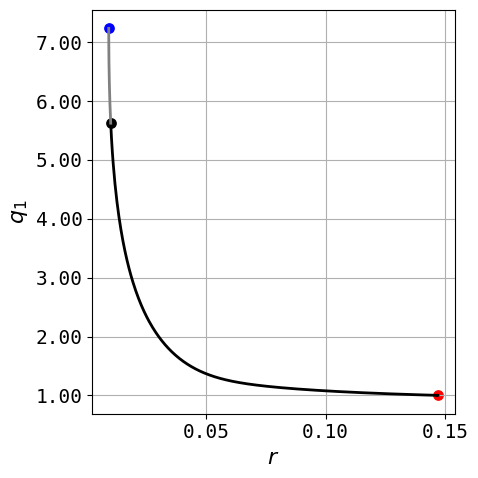

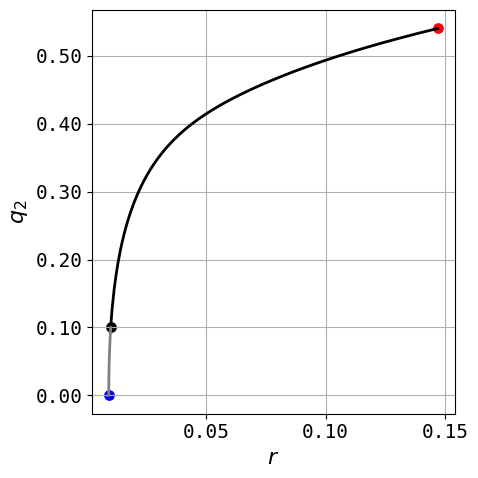

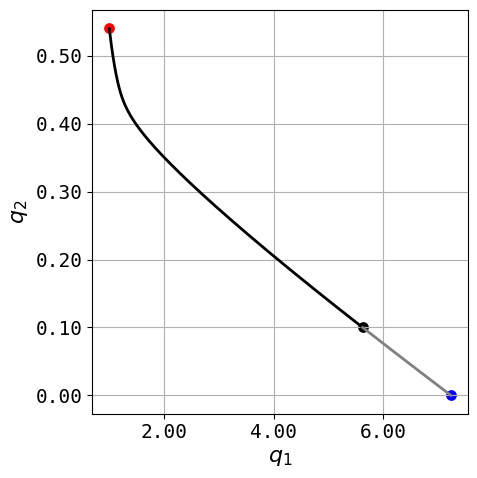

In [27]:
pprint.pprint(points, stream=open(fname + '.txt', 'a'))
plotter(ans[4], result[4]['plus']['last']['time'], result[4]['minus']['last']['time']/1, 100000, fname)
    
    
